In [25]:
from tensorflow.keras.applications import ResNet50
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import torch
from custom_transformers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from augmentation_generator_batch_size import *
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [26]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

## Load data

In [2]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


## Test Data Generator (with fraction 60% to visualize results)

Adding new samples

In [27]:
random_squares_cutout = RandomSquaresCutout(max_number_of_squares=10,max_size_ratio=0.1,color=False)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=16, shuffle=True, augmentor= random_squares_cutout, augment_fraction=0.2, overwrite=False)

batch_x, batch_y = generator[0]

In [28]:
print(batch_x.shape)

(16, 224, 224, 3)


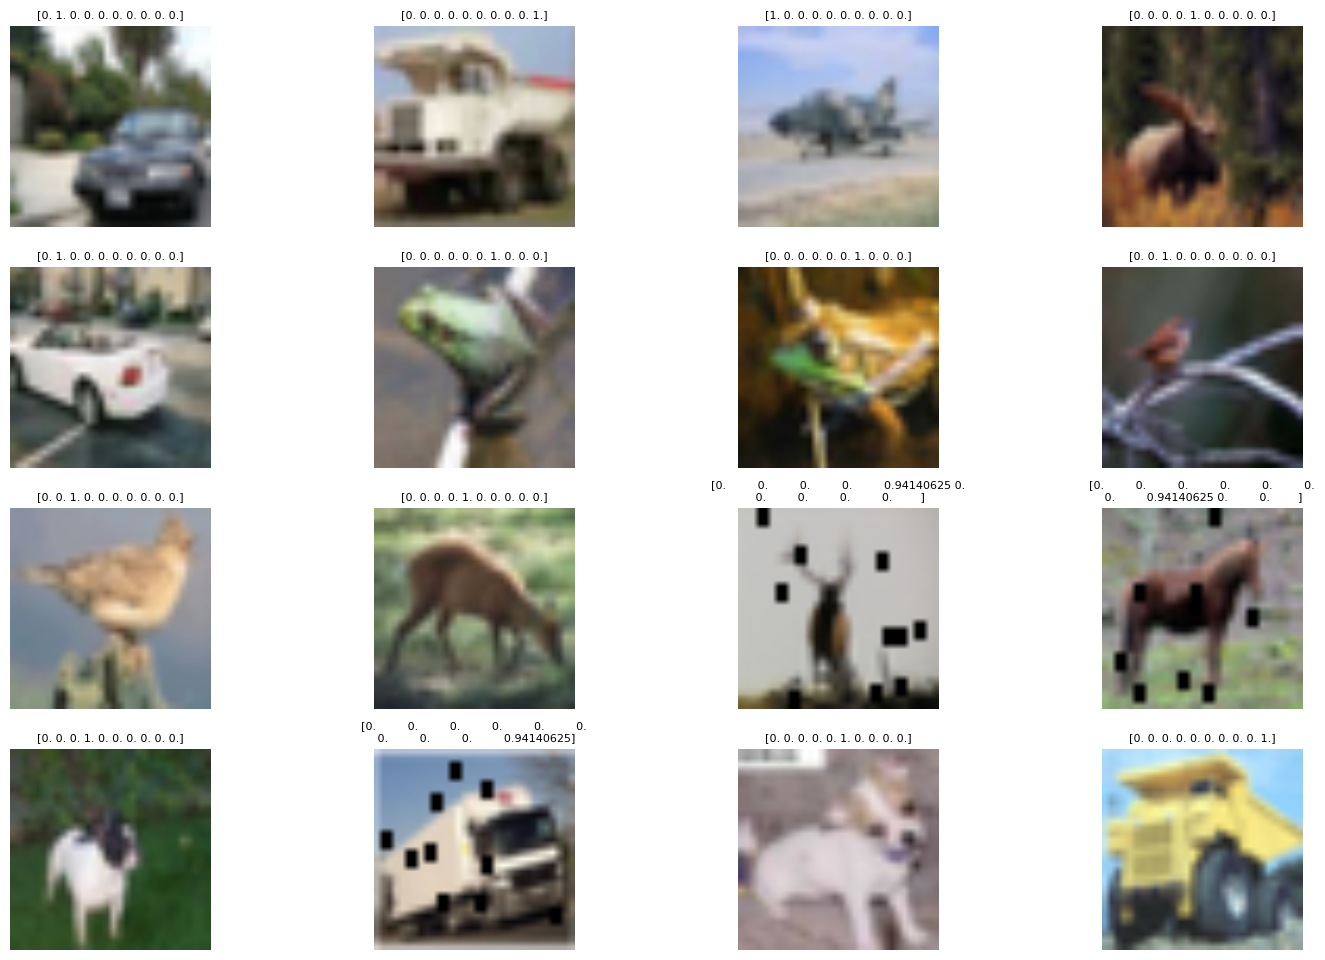

In [29]:
#function to denormalize Restnet preprocessing for visualization purposes
def denormalize_resnet(x):
    x = x.copy()
    x[..., 0] += 103.939  # Blue
    x[..., 1] += 116.779  # Green
    x[..., 2] += 123.68   # Red
    x = x[..., ::-1]
    x = np.clip(x / 255.0, 0, 1)
    return x

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## Restnet Training - Random Squares

In [31]:
random_squares_cutout = RandomSquaresCutout(max_number_of_squares=10,max_size_ratio=0.1,color=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

train_gen = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32,
    augmentor=random_squares_cutout, augment_fraction=0.2, overwrite=False)

test_gen = AugmentedCIFAR10Generator(X_test, Y_test,
    batch_size=32, shuffle=False, augmentor=None)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_gen, validation_data=test_gen, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 225s 114ms/step - accuracy: 0.7406 - loss: 0.7754 - val_accuracy: 0.8787 - val_loss: 0.3435
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 210s 112ms/step - accuracy: 0.7988 - loss: 0.6673 - val_accuracy: 0.7789 - val_loss: 1.1935
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 222s 118ms/step - accuracy: 0.7610 - loss: 1.8073 - val_accuracy: 0.8475 - val_loss: 1.7784
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 212s 113ms/step - accuracy: 0.7535 - loss: 4.5418 - val_accuracy: 0.8663 - val_loss: 2.9384
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 211s 112ms/step - accuracy: 0.7564 - loss: 8.8591 - val_accuracy: 0.8708 - val_loss: 4.7352


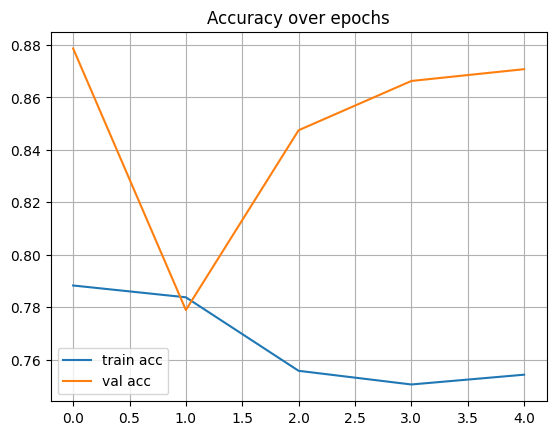

In [32]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.grid(True)
plt.show()

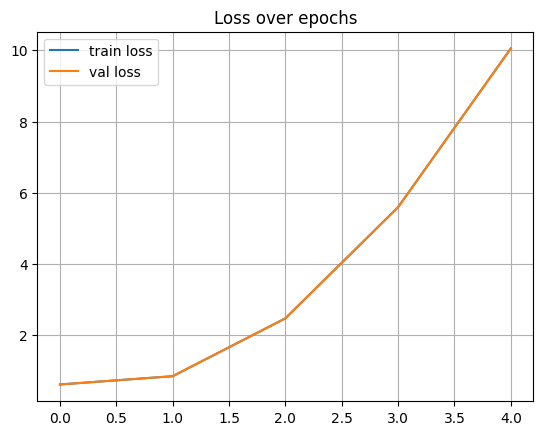

In [33]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.grid(True)
plt.show()

In [34]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Accuracy on test set: {test_acc:.2%}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.8699 - loss: 4.7919
Accuracy on test set: 87.08%


In [35]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

<ipython-input-38-8eea66e6b0ca>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_label_index = int(Y_test[image_number])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


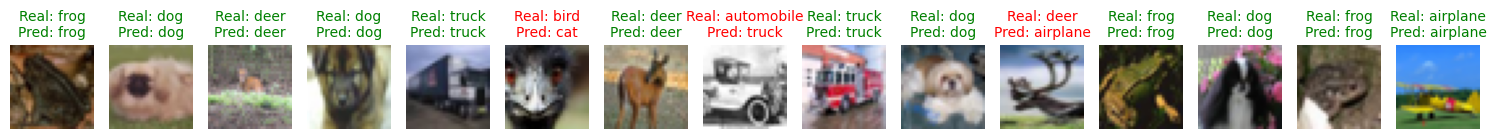

In [38]:
def label_check(image_numbers):
    fig, axes = plt.subplots(1, len(image_numbers), figsize=(15, 5))

    for i, image_number in enumerate(image_numbers):
        ax = axes[i] if len(image_numbers) > 1 else axes

        image = X_test[image_number]
        ax.imshow(image)
        ax.axis('off')

        image_resized = cv2.resize(image, (224, 224))
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        image_input = image_preprocessed.reshape(1, 224, 224, 3)

        predicted_label_index = model.predict(image_input).argmax()
        predicted_label = labels[predicted_label_index]

        actual_label_index = int(Y_test[image_number])
        actual_label = labels[actual_label_index]

        correct = predicted_label_index == actual_label_index
        color = 'green' if correct else 'red'

        ax.set_title(f"Real: {actual_label}\nPred: {predicted_label}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()
label_check(range(30,45))

In [39]:
model.save("resnet_model_random_squares.keras")
model.save("resnet_model_random_squares.h5")

trying smaller cutout (max size ration 0.1 -> 0.05)

In [40]:
random_squares_cutout_005 = RandomSquaresCutout(max_number_of_squares=10,max_size_ratio=0.1,color=False)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=16, shuffle=True, augmentor= random_squares_cutout_005, augment_fraction=0.2, overwrite=False)

batch_x, batch_y = generator[0]

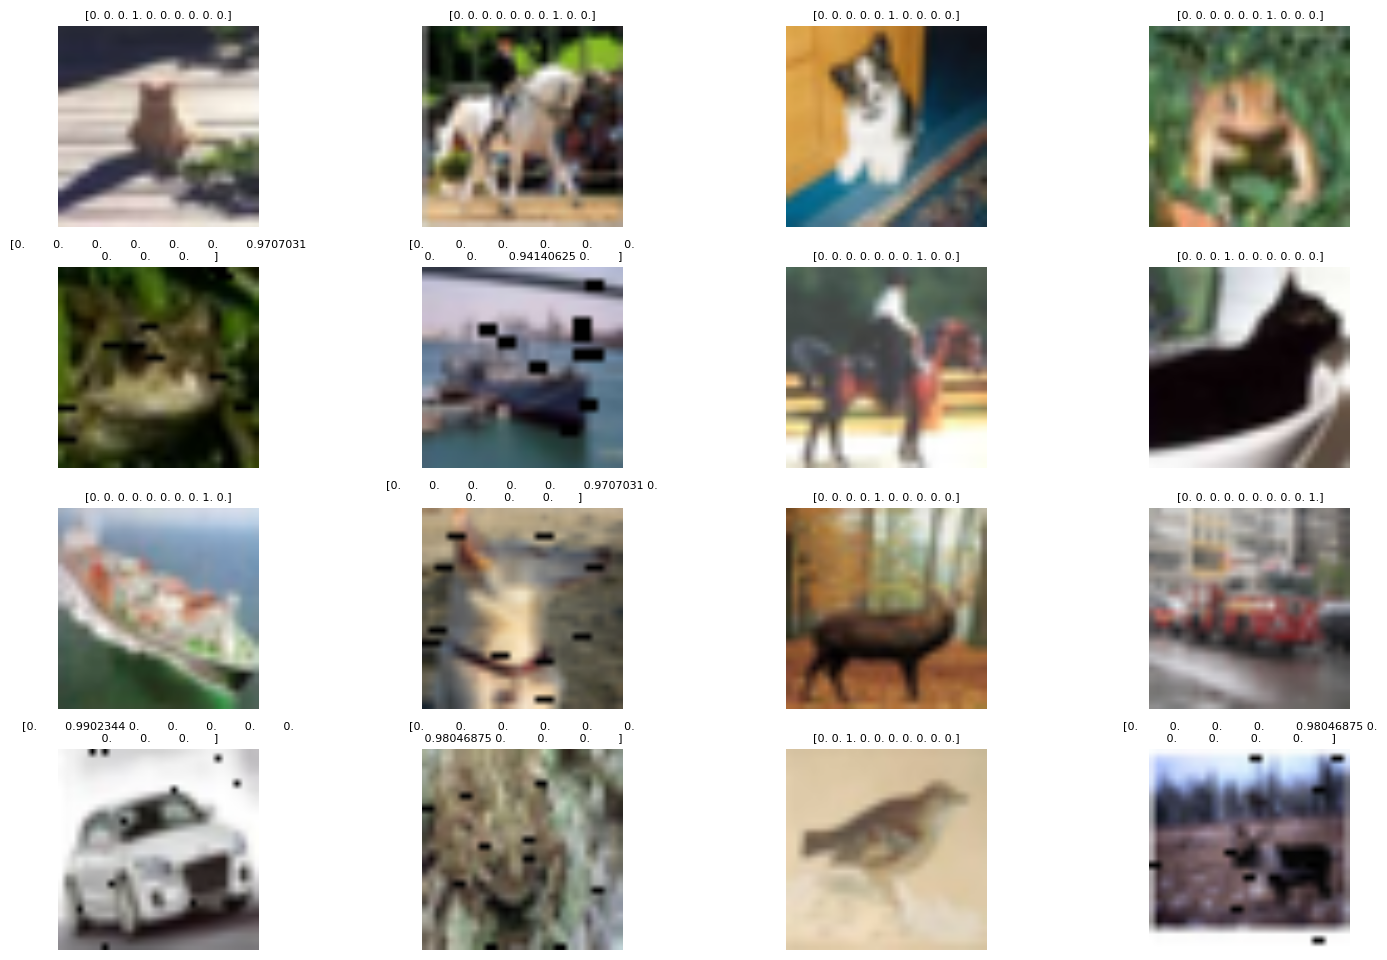

In [41]:
n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

In [42]:
random_squares_cutout_005 = RandomSquaresCutout(max_number_of_squares=10,max_size_ratio=0.05,color=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

train_gen = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32,
    augmentor=random_squares_cutout_005, augment_fraction=0.2, overwrite=False)

test_gen = AugmentedCIFAR10Generator(X_test, Y_test,
    batch_size=32, shuffle=False, augmentor=None)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_gen, validation_data=test_gen, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 227s 116ms/step - accuracy: 0.7505 - loss: 0.7569 - val_accuracy: 0.8856 - val_loss: 0.3377
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 211s 113ms/step - accuracy: 0.8443 - loss: 0.4526 - val_accuracy: 0.8907 - val_loss: 0.3165
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 211s 113ms/step - accuracy: 0.8505 - loss: 0.4310 - val_accuracy: 0.8932 - val_loss: 0.3074
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 211s 112ms/step - accuracy: 0.8579 - loss: 0.4108 - val_accuracy: 0.8984 - val_loss: 0.3008
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 211s 113ms/step - accuracy: 0.8651 - loss: 0.3920 - val_accuracy: 0.8954 - val_loss: 0.3091


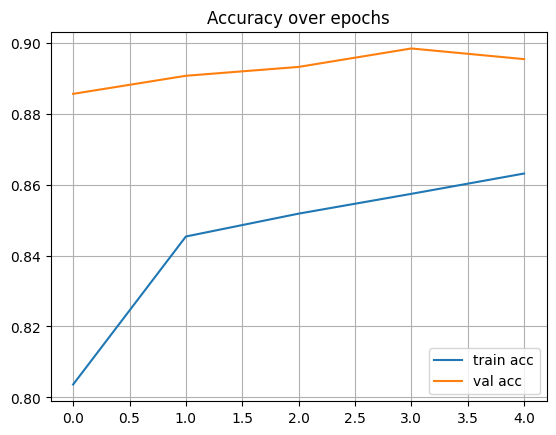

In [43]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.grid(True)
plt.show()

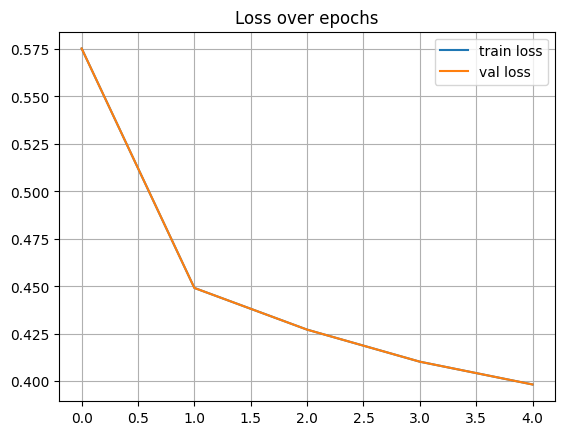

In [44]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.grid(True)
plt.show()

In [45]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Accuracy on test set: {test_acc:.2%}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.8925 - loss: 0.3128
Accuracy on test set: 89.54%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


<ipython-input-46-8eea66e6b0ca>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_label_index = int(Y_test[image_number])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


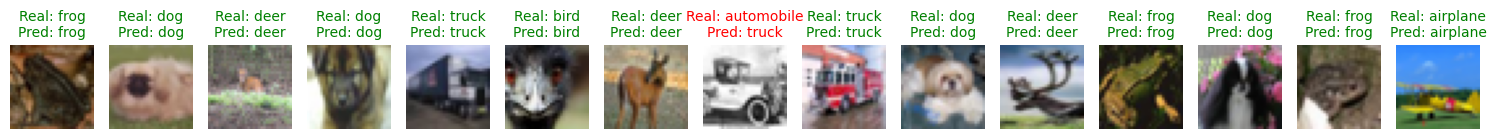

In [46]:
def label_check(image_numbers):
    fig, axes = plt.subplots(1, len(image_numbers), figsize=(15, 5))

    for i, image_number in enumerate(image_numbers):
        ax = axes[i] if len(image_numbers) > 1 else axes

        image = X_test[image_number]
        ax.imshow(image)
        ax.axis('off')

        image_resized = cv2.resize(image, (224, 224))
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        image_input = image_preprocessed.reshape(1, 224, 224, 3)

        predicted_label_index = model.predict(image_input).argmax()
        predicted_label = labels[predicted_label_index]

        actual_label_index = int(Y_test[image_number])
        actual_label = labels[actual_label_index]

        correct = predicted_label_index == actual_label_index
        color = 'green' if correct else 'red'

        ax.set_title(f"Real: {actual_label}\nPred: {predicted_label}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()
label_check(range(30,45))

In [48]:
model.save("resnet_model_random_squares.keras")
model.save("resnet_model_random_squares.h5")

trying more augementation fraction 0.2 -> 0.4

In [49]:
random_squares_cutout = RandomSquaresCutout(max_number_of_squares=10,max_size_ratio=0.05,color=False)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

train_gen = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32,
    augmentor=random_squares_cutout, augment_fraction=0.4, overwrite=False)

test_gen = AugmentedCIFAR10Generator(X_test, Y_test,
    batch_size=32, shuffle=False, augmentor=None)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_gen, validation_data=test_gen, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 264s 115ms/step - accuracy: 0.7454 - loss: 0.7680 - val_accuracy: 0.8809 - val_loss: 0.3506
Epoch 2/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 242s 110ms/step - accuracy: 0.8402 - loss: 0.4595 - val_accuracy: 0.8922 - val_loss: 0.3109
Epoch 3/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 242s 110ms/step - accuracy: 0.8467 - loss: 0.4442 - val_accuracy: 0.8943 - val_loss: 0.3074
Epoch 4/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 252s 115ms/step - accuracy: 0.8492 - loss: 0.4366 - val_accuracy: 0.8881 - val_loss: 0.3243
Epoch 5/5
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 252s 111ms/step - accuracy: 0.8351 - loss: 0.5137 - val_accuracy: 0.8792 - val_loss: 0.3646


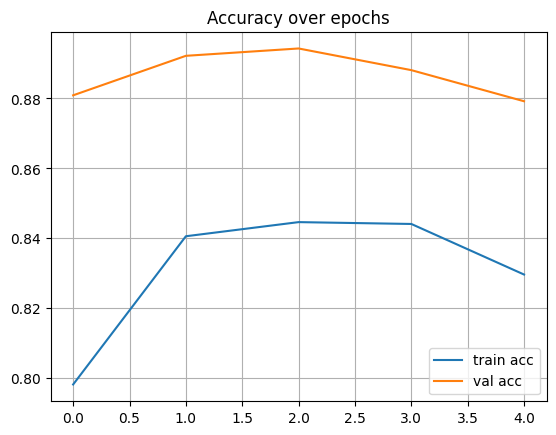

In [50]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.grid(True)
plt.show()

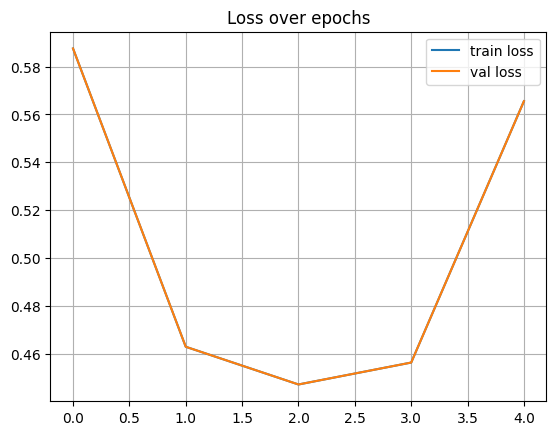

In [51]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.grid(True)
plt.show()

In [52]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Accuracy on test set: {test_acc:.2%}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 96ms/step - accuracy: 0.8804 - loss: 0.3624
Accuracy on test set: 87.92%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


<ipython-input-53-8eea66e6b0ca>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_label_index = int(Y_test[image_number])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


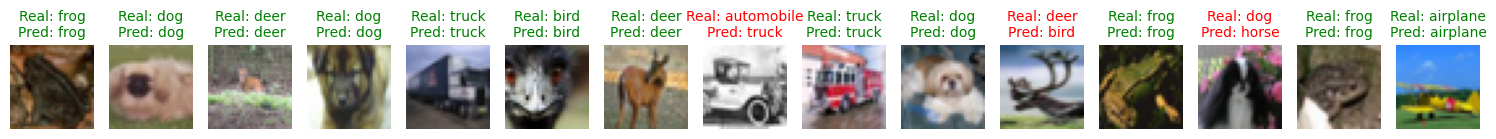

In [53]:
def label_check(image_numbers):
    fig, axes = plt.subplots(1, len(image_numbers), figsize=(15, 5))

    for i, image_number in enumerate(image_numbers):
        ax = axes[i] if len(image_numbers) > 1 else axes

        image = X_test[image_number]
        ax.imshow(image)
        ax.axis('off')

        image_resized = cv2.resize(image, (224, 224))
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        image_input = image_preprocessed.reshape(1, 224, 224, 3)

        predicted_label_index = model.predict(image_input).argmax()
        predicted_label = labels[predicted_label_index]

        actual_label_index = int(Y_test[image_number])
        actual_label = labels[actual_label_index]

        correct = predicted_label_index == actual_label_index
        color = 'green' if correct else 'red'

        ax.set_title(f"Real: {actual_label}\nPred: {predicted_label}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()
label_check(range(30,45))

In [54]:
model.save("resnet_model_random_squares.keras")
model.save("resnet_model_random_squares.h5")